# 12. Textúry

In [1]:
import numpy as np, matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.color import label2rgb
from skimage.filters.rank import entropy
from skimage import color, io, morphology, filters
from skimage.feature import greycomatrix, greycoprops

plt.rc('font', **{'family' : 'DejaVu Sans', 'weight' : 'normal', 'size' : 18})

Povrch mnohých objektov má charakteristický vzor, tzv. textúru. Textúry môžu mať rôzne vizuálne
vlastnosti a intuitívne ich hodnotíme, ako „jemné“, „drsné“, „pravidelné“, „výrazné“ a pod. Pri
rozpoznávaní textúr (segmentácii na základe textúrnych informácií) nie je možné posudzovať
jednotlivé body obrazu, ako sme to robili v prípade segmentácie na základe jasu, rsp. farby. Je
potrebné dať do vzťahu body obrazu s ich okolím. S využitím informácie o textúre je možné
segmentovať objekty, ktoré nemusia byť odlíšiteľné na základe iných kritérií. Pokúsime sa
segmentovať obrázok mačkovitej šelmy:

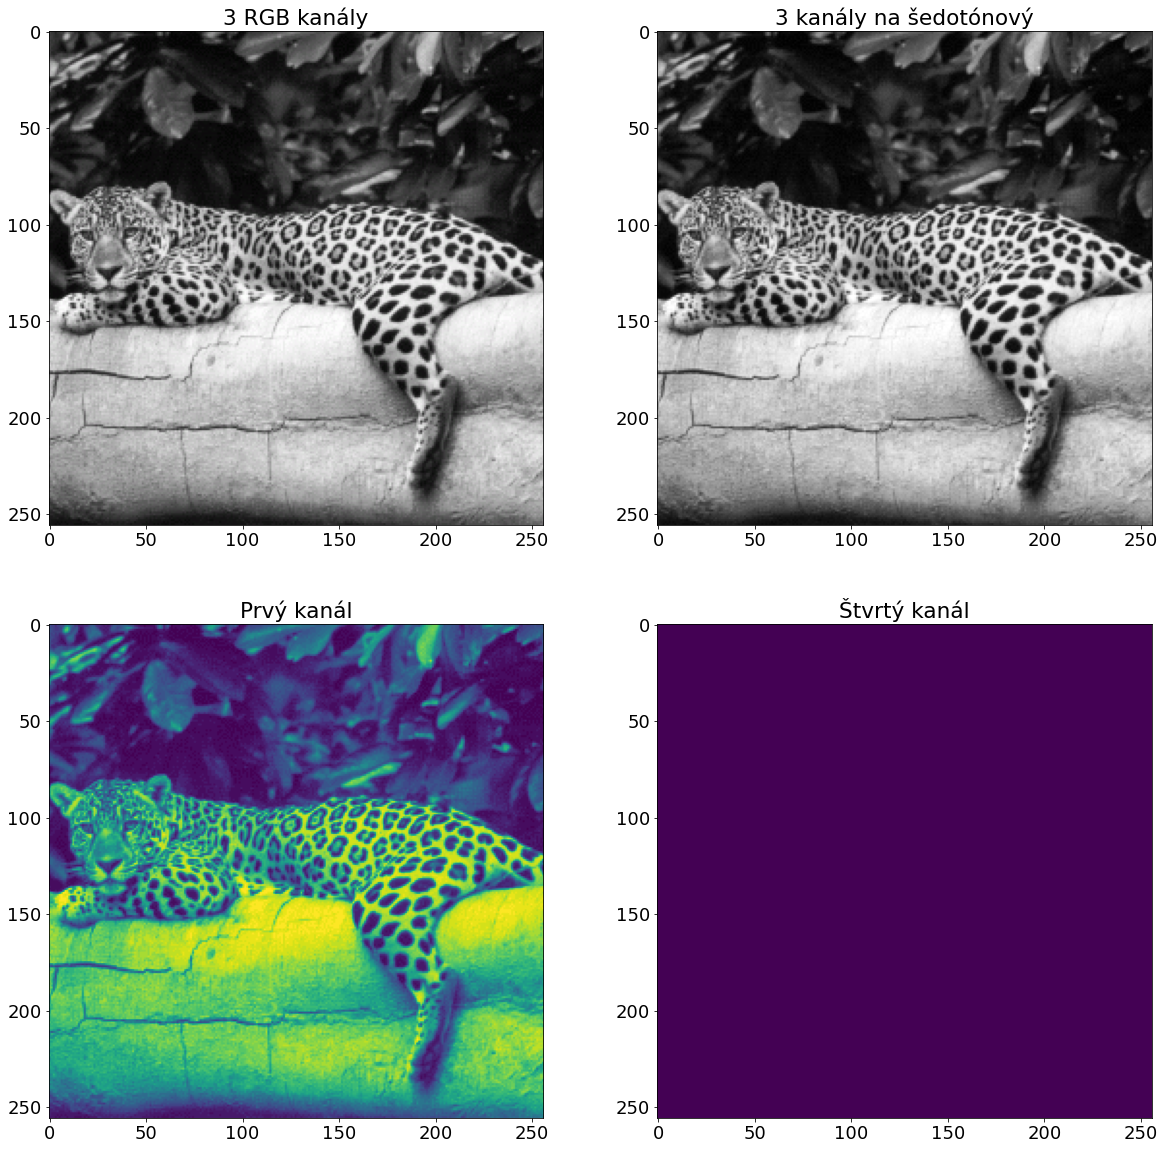

In [2]:
I = io.imread('imgs/jaguar.gif')

plt.figure(figsize= (20, 20))
plt.subplot(221)
plt.title('3 RGB kanály')
plt.imshow(I[..., 0:3])

plt.subplot(222)
plt.title('3 kanály na šedotónový')
I_gray= (color.rgb2gray(I[..., 0:3])*255).astype(np.uint8)
plt.imshow(I_gray, cmap= 'gray')

plt.subplot(223)
plt.title('Prvý kanál')
plt.imshow(I[..., 0])

plt.subplot(224)
plt.title('Štvrtý kanál')
plt.imshow(I[..., 3])

Na základe subjektívneho dojmu by sme mohli povedať, že na obrázku sú tri základné textúry,
textúra jaguára, listov v pozadí a kmeňa stromu. Aby sme mohli obrázok segmentovať algoritmicky,
musíme nájsť kvantifikovateľné vlastnosti, ktoré by textúry popisovali. Budeme pri tom
posudzovať malé výrezy pôvodného obrázku. Jedným z atribútov popisujúcich textúry je entropia,
ktorá odráža mieru náhodnosti v textúre. Entropiu pre každý pixel na základe jeho jasu a jasov
pixelov jeho okolia vypočítame funkciou *entropy*.

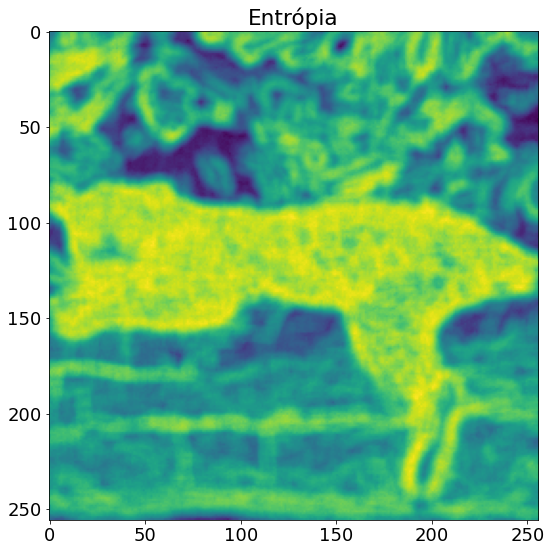

In [3]:
plt.figure(figsize= (9, 9))
plt.title('Entrópia')
im_entropy = entropy(I_gray, morphology.disk(5))
plt.imshow(im_entropy)

Z obrázku je zrejmé, že entropia pomerne dobre odlišuje textúru jaguára od zvyšku obrázku.
Existujú však aj mnohé iné atribúty textúr. Niektoré z nich teraz vypočítame pre rovnaké okolie ako
vyššie, konkrétne:
 *  Kontrast, rozdiel intenzitami jasu pixelu a jeho susedov v celom výreze. Kontrast je nulový pre konštantný obraz.
 * Korelácia, štatistická miera závislosti hodnoty jasu pixelu od hodnôt jasov jeho susedov.
 *  Energia, určuje mieru usporiadanosti obrazu.
 * Homogénnosť, kvalita určujúca mieru podobnosti rôznych oblastí obrazu.

Zaujímavý tutoriál týkajúci sa výpočtu atribútov textúr môžete nájsť na:
 * https://prism.ucalgary.ca/handle/1880/51900

Odstup vyšetrovaných pixelov ak nie je definované inak je 0 riadkov a 1 stĺpec, t.j. vyšetrujú sa
škálované hodnoty jasu susedných pixelov v horizontálnom smere. Inicializujeme tieto nulové matice o
rozmere poľa *im_entropy*.

In [4]:
im_contrast = np.zeros(im_entropy.shape)
im_correlation = np.zeros(im_entropy.shape)
im_energy = np.zeros(im_entropy.shape)
im_homogeneity = np.zeros(im_entropy.shape)

Teraz budeme v cykle prechádzať všetky výrezy obrázku. Pre každý výrez vypočítame kookurenčnú
maticu a hodnoty sledovaných vlastností. Tieto zapíšeme do príslušných matíc.

In [5]:
distances = [1]
angles = [0]
properties= ['contrast', 'correlation', 'energy', 'homogeneity']
window_size = 9

for i in tqdm(range(0, im_entropy.shape[0] - window_size)):
    for j in range(0, im_entropy.shape[0] - window_size):

        glcm = greycomatrix(I_gray[i:i + window_size, j:j + window_size],
                            distances= distances,
                            angles= angles,
                            symmetric= True,
                            normed= True)
        feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])
        im_contrast[i, j] = feats[0]
        im_correlation[i, j] = feats[1]
        im_energy[i, j] = feats[2]
        im_homogeneity[i, j] = feats[3]

Teraz môžeme vizualizovať hodnoty vypočítaných textúrnych vlastností:

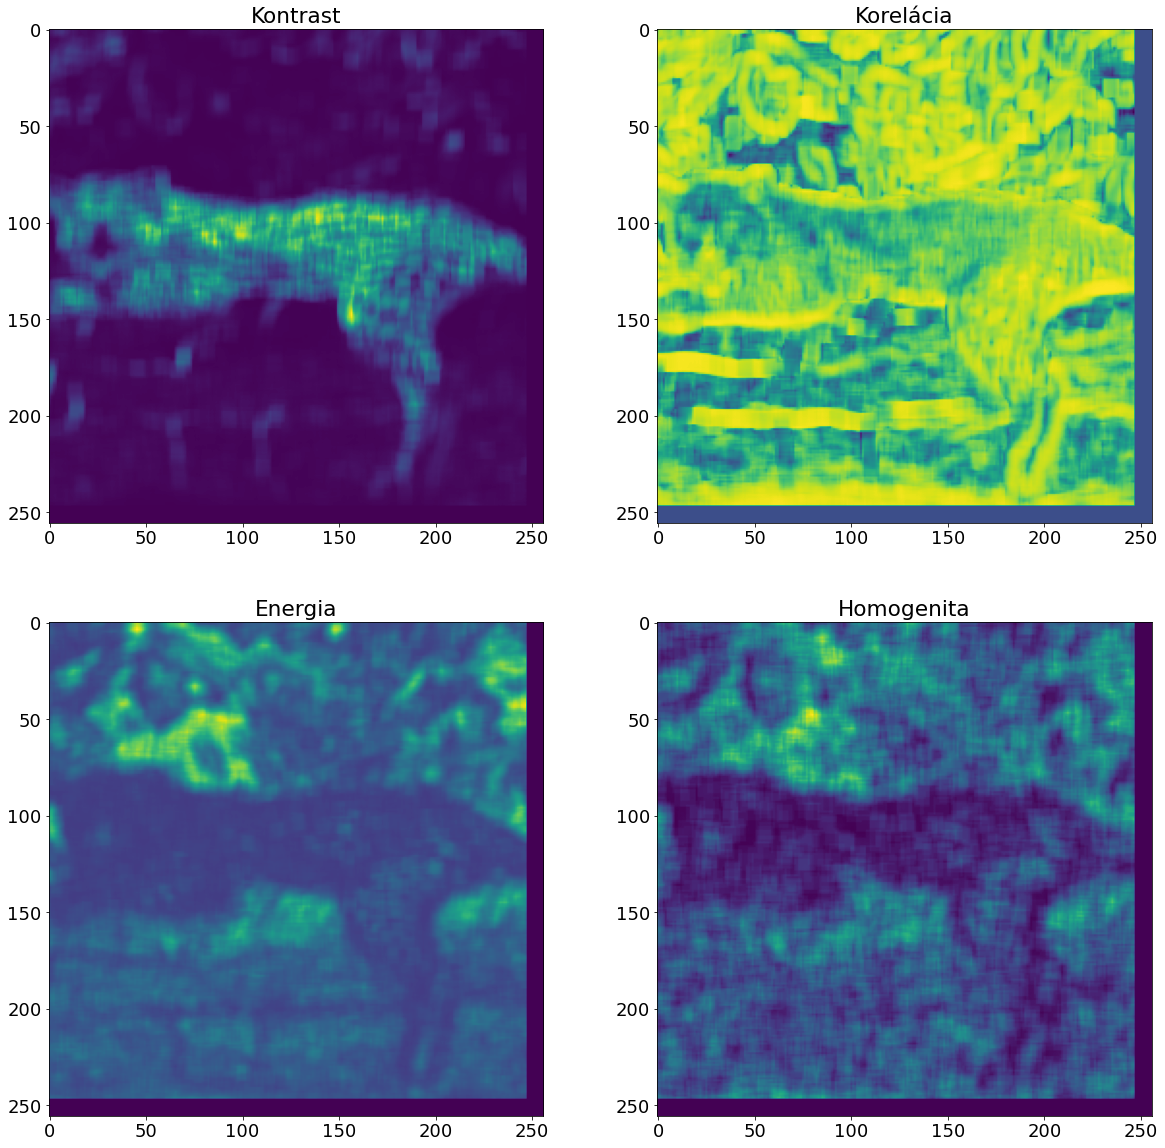

In [6]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('Kontrast')
plt.imshow(im_contrast)

plt.subplot(222)
plt.title('Korelácia')
plt.imshow(im_correlation)

plt.subplot(223)
plt.title('Energia')
plt.imshow(im_energy)

plt.subplot(224)
plt.title('Homogenita')
plt.imshow(im_homogeneity)

Vizuálnou analýzou obrázkov môžeme usúdiť, že:
 * Energia je nízka v textúre jaguára a stredná až vysoká vo zvyšku obrázku.
 * Entropia je výrazne záporne korelovaná s energiou.
 * Kontrast je vysoký v textúre jaguára a nízky vo zvyšku obrázku.

Textúru jaguára by teda malo byť pomerne jednoduché segmentovať na základe informácie o
kontraste a energii sledovaného výrezu. Ďalej sa teda zameriame na kontrast a energiu.
Vyhladíme výstup mediánovým filtrom pre potlačenie šumu a prevedieme ich hodnoty na interval
<0,1>.

Diagram rozptylu je výhodný nástroj pri štúdiu závislostí dvoch alebo troch premenných. Teraz
zostrojíme diagram, kde na os X budeme vynášať hodnotu energie a na os Y hodnotu kontrastu.
Každá dvojica hodnôt energie a kontrastu zodpovedajúca niektorému pixelu sa objaví v grafe,
ako modrý bod.

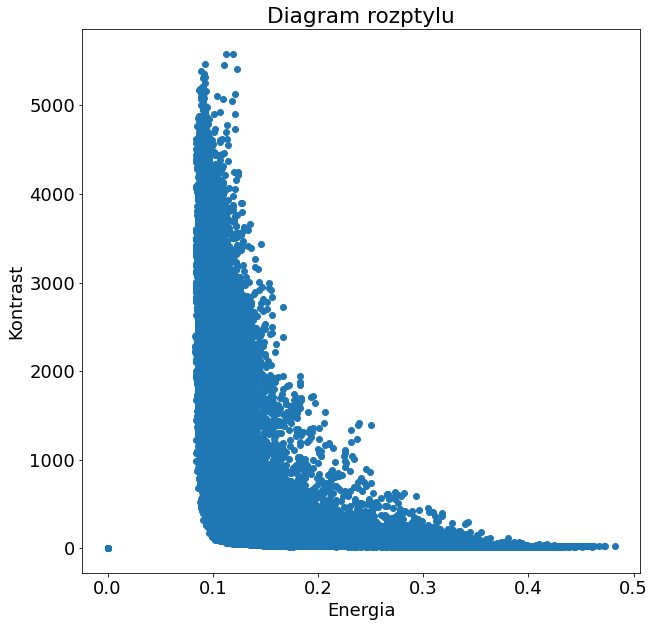

In [7]:
plt.figure(figsize= (10, 10))
plt.title('Diagram rozptylu')
plt.xlabel('Energia')
plt.ylabel('Kontrast')
plt.scatter(im_energy.ravel(), im_contrast.ravel())

V diagrame rozptylu môžeme pozorovať v zásade tri typy bodov:
 1. Body s nižšou energiou a vyšším kontrastom.
 2. Body s nižším kontrastom aj energiou.
 3. Body s nižším kontrastom a vyššou energiou.

Z obrázkov vyššie sme usúdili, že textúra jaguára je charakterizovaná vyšším kontrastom a nižšou
energiou. Segmentujeme pixely, ktoré zodpovedajú týmto kritériám:

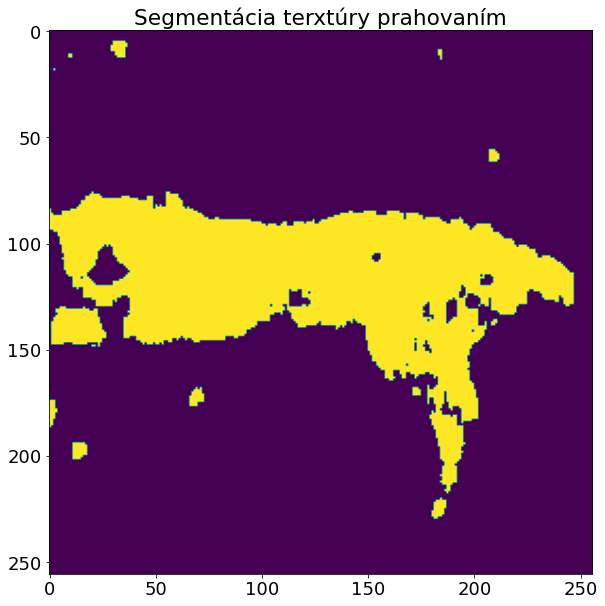

In [8]:
plt.figure(figsize= (10, 10))
plt.title('Segmentácia terxtúry prahovaním')
plt.imshow(np.logical_and(im_energy < 0.15, im_contrast > 1000))

Podarilo sa nám segmentovať jaguára na základe jeho špecifickej textúry. Vo všeobecnosti však
popisujeme textúru viacerými atribútmi – príznakmi. Bolo by vhodné automaticky segmentovať
obrázok na oblasti s rôznymi textúrami. Na tento účel teraz použijeme jednoduchú metódu pre
zhlukovanie. Cieľom zhlukovania je rozdeliť priestor príznakov na oblasti, v ktorých sa nachádzajú
vzorky s podobnými vlastnosťami. Implementujeme jednoduchý vlastný algoritmus založený na
princípe „víťaz berie všetko“ (Winner Takes All, WTA). Najskôr definujeme množinu vzoriek a
parametre algoritmu:

In [9]:
im_energy /= np.max(im_energy)
im_contrast /= np.max(im_contrast)

energy = np.expand_dims(im_energy, axis= 2)
contrast = np.expand_dims(im_contrast, axis= 2)

X = np.concatenate((energy, contrast), axis= 2)
n_iter = 5
n_centers = 3
alfa = 0.07
centers = np.random.rand(n_centers, X.shape[2])

for i in range(0, n_iter):
    for x in np.random.permutation(X.shape[0]):
        for y in np.random.permutation(X.shape[1]):
            item = X[x, y]
            distances = centers - np.tile(item, (n_centers, 1))
            distances = np.sum((distances**2), axis= 1)
            [value, indx] = [min(distances), np.where(distances == min(distances))]
            centers[indx] = (item - centers[indx])*alfa + centers[indx]

output = np.zeros(im_contrast.shape)
for x in range(0, X.shape[0]):
    for y in range(0, X.shape[1]):
        item = X[x, y]
        distances = centers - np.tile(item, (n_centers, 1))
        distances = np.sum((distances**2), axis= 1)
        [value, indx] = [min(distances), np.where(distances == min(distances))]
        output[x, y] = indx[0]

<ipython-input-10-de1ecf3d5b46>:3: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  RGB_label = label2rgb(output)


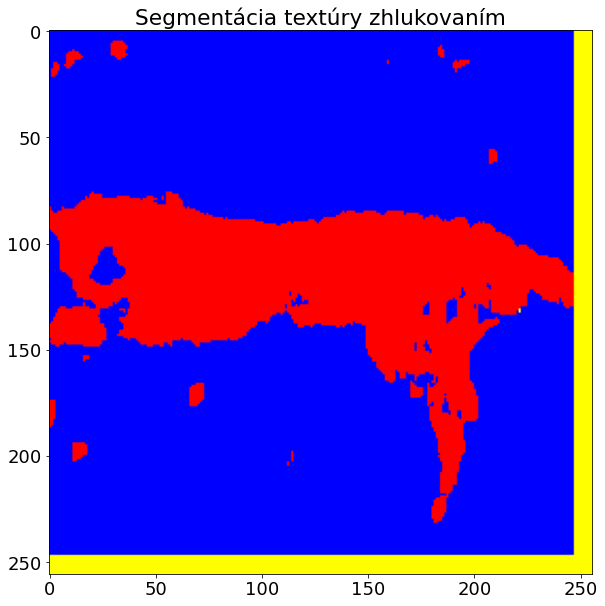

In [10]:
plt.figure(figsize= (10, 10))
plt.title('Segmentácia textúry zhlukovaním')
RGB_label = label2rgb(output)
plt.imshow(RGB_label)

Vzhľadom na to, že stredy zhlukov sú inicializované náhodnými číslami a vzorky sú prezentované v
náhodnom poradí priebeh algoritmu nie je deterministický. Po opätovnom spustení sa výsledok
bude mierne odlišovať. Vidíme, že textúra jaguára bola pomerne spoľahlivo oddelená.


Stredy zhlukov sú označené červenými X. Priamky v obrázku zodpovedajú bodom, ktoré sú
rovnako vzdialené od dvojíc stredov a predstavujú de facto hranice zhlukov. Priamky tvoria tzv.
Voronoiov diagram. Na záver zobrazíme algoritmicky segmentovanú časť pôvodného obrázku a jej
kontúru. Na určenie, ktorý zhluk reprezentuje jaguára použijeme zaradenie pixelu, ktorý ručne
vyberieme a vieme, že patrí obrazu zvieraťa.

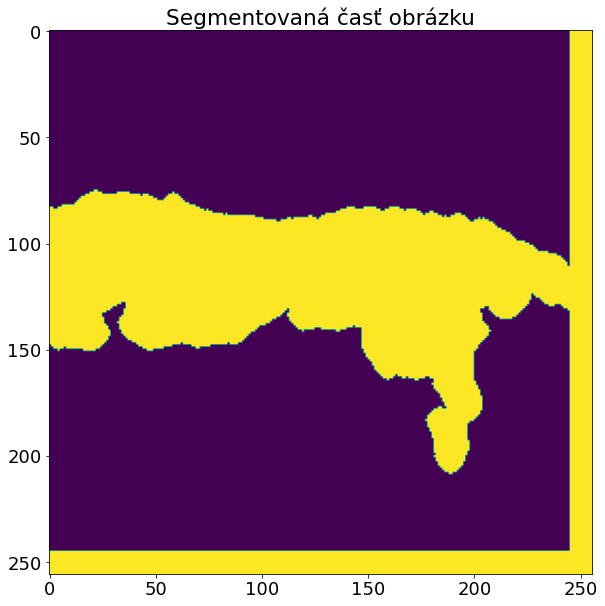

In [11]:
plt.figure(figsize= (10, 10))
plt.title('Segmentovaná časť obrázku')
B = RGB_label[:, :, 2]
out = filters.threshold_otsu(B)
mask = B < out
finalMask = morphology.remove_small_holes(morphology.dilation(morphology.opening(
                                    mask, morphology.disk(4)), morphology.disk(2)), 256)
plt.imshow(finalMask)

Najskôr rozšírime segmentačnú masku o okraj, ktorý sme pri spracovaní odstránili, tak aby
bola zhodná s veľkosťou pôvodného obrázku a inicializujeme ju nulami. Morfologickou operáciou
odstránime malé fragmenty a uzavrieme malé diery.

In [12]:
# Matlab
# boundary = bwperim(jaguar);
#
# R = I_gray;
# R(boundary) = 255;
# G = I_gray;
# G(boundary) = 0;
# B = I_gray;
# B(boundary) = 0;
# I_RGB = cat(3,R,G,B);
#
# figure, imshow(I_RGB); title('Okraj segmentovanej oblasti')

# Úloha:
 Pokúste sa segmentovať umelo vytvorený obrázok textúr: *imgs/artificial_texture.jpg*